In [1]:
import trimesh
import numpy as np
import sympy as sy
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from SkeletonOfBeam import SkeletonOfBeam
from SkeletonOfBeam import GeometryToolBox

In [2]:
mesh = trimesh.load_mesh("cantilever.stl")

1. search general paper for similar papers
2. liter review, related research, the difference, similarity (Intro), similar contexts
3. doc? ok

1. combine info from cv and fem
2. properties: eg. cross section (avg?), changes of intersections, n = 10
3. for each part: mean cross section, std, estimation
4. continuous curve, story

## 1. Create

In [4]:
sob = SkeletonOfBeam(mesh, [1, 0, 0])
sob.getScaleAlongSkeletonVec()
sob.getIntersectionsFromStep(step=1)
sob.getSkeletonPoints()
sob.getNewCoordinate()
sob.getProjections()
sob.getSkeletonEqs()
sob.getDerivativeSkeletonEqs()
sob.getNewSkeletonPoints()
sob.getNewIntersections()

In [5]:
sob.Intersections

[<trimesh.Path3D(vertices.shape=(426, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(347, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(361, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(337, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(352, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(361, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(358, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(323, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(348, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(358, 3), len(entities)=2)>,
 <trimesh.Path3D(vertices.shape=(333, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(351, 3), len(entities)=1)>,
 <trimesh.Path3D(vertices.shape=(353, 3), len(entities)=2)>,
 <trimesh.Path3D(vertices.shape=(364, 3), len(entities)=2)>,
 <trimesh.Path3D(vertices.shape=(391, 3), len(entities)=2)>,
 <trimesh.Path3D(vertices.shape=(372, 3), len(entities)=1)>,
 <trimesh.Path3D(vertice

In [6]:
n = 3
# interval = 1/n
m = n*4 + 1

In [7]:
L = sob.L
xVec, yVec, zVec = sob.XYZCoordinate
O = sob.coorOrigin
u_xy = sob.u_xyPlane
u_xz = sob.u_xzPlane

## 2. Get $\xi$

In [8]:
if m > 2:
    dis = 1/(m-1)
    xis_global = [(i+1)*dis for i in range(m-2)]
xis_global = [0] + xis_global + [1]
xis_global

[0,
 0.08333333333333333,
 0.16666666666666666,
 0.25,
 0.3333333333333333,
 0.41666666666666663,
 0.5,
 0.5833333333333333,
 0.6666666666666666,
 0.75,
 0.8333333333333333,
 0.9166666666666666,
 1]

In [9]:
xis_local = (np.array(xis_global) % (1/n)) / (1/n)
xis_local[-1] = 1
separateIndex = [0]

for i in range(len(xis_local)):
    if i == 0:
        pass
    else:
        if xis_local[i] <= xis_local[i-1]:
            separateIndex.append(i)
        
separateIndex.append(-1)

In [10]:
xis_local

array([0.  , 0.25, 0.5 , 0.75, 0.  , 0.25, 0.5 , 0.75, 0.  , 0.25, 0.5 ,
       0.75, 1.  ])

In [11]:
separateIndex

[0, 4, 8, -1]

## 3. Get u vector in y and z

In [20]:
uYs = []
uZs = []
for xi_value in xis_global:
    uY = u_xy.evalf(subs={'xi': xi_value})
    uZ = u_xz.evalf(subs={'xi': xi_value})
    uYs.append(uY)
    uZs.append(uZ)

In [21]:
uYs

[0.00913184665597121,
 0.103548093515809,
 0.213929255889453,
 0.338404879405202,
 0.475104509691352,
 0.622157692376199,
 0.777693973088042,
 0.939842897455177,
 1.10673401110590,
 1.27649685966851,
 1.44726098877130,
 1.61715594404258,
 1.78431127111063]

## 4. Get N matrix in y and z

In [22]:
N = np.zeros((m, 2*(n+1)))

In [23]:
pts = []
segL = L/n
for i in range(len(separateIndex)-1):        
    xis = xis_local[separateIndex[i]:separateIndex[i+1]]
    if separateIndex[i+1] == -1:
        xis = np.append(xis, xis_local[-1])
    
    if i == n-1:
        N[separateIndex[i]:, i*2:] = SkeletonOfBeam.H(xis, segL)
    else:
        N[separateIndex[i]:separateIndex[i+1], i*2:i*2+4] = SkeletonOfBeam.H(xis, segL)

In [24]:
N

array([[ 1.        ,  0.        ,  0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.84375   ,  1.734375  ,  0.15625   , -0.578125  ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.5       ,  1.54166667,  0.5       , -1.54166667,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.15625   ,  0.578125  ,  0.84375   , -1.734375  ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.84375   ,  1.734375  ,  0.15625   ,
        -0.578125  ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.5       ,  1.54166667,  0.5       ,
        -1.54166667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.15625   ,  0.578125  ,  0.84375   ,
        -1.734375  ,  0.        ,  0.        ],
       [ 0.        ,  0.        

## 5. $a = N^{-1} u$

In [25]:
aYs = np.dot(np.linalg.pinv(N), uYs)
aYs

array([0.00913184665597205, 0.0278303689661750, 0.475104509691352,
       0.0461150753126849, 1.10673401110590, 0.0546936400546850,
       1.78431127111062, 0.0535660631921754], dtype=object)

In [26]:
aZs = np.dot(np.linalg.pinv(N), uZs)
aZs

array([-0.00466006992917711, -0.00459723947228540, 0.0264651901403142,
       0.00822967324392120, 0.163437529509932, 0.0125671517655724,
       0.301553926446820, 0.00841519609266816], dtype=object)

In [ ]:
SegsOfSOB

## Implemented in class

In [38]:
class nBeams:
    mSob = None
    mesh = None 
    n = None
    
    aYs = []
    aZs = []
    
    nSobs = []
    
    us_xyPlane = []
    us_xzPlane = []
    dudxs_xyPlane = []
    dudxs_xyPlane = []
    
    def __init__(self, motherSob, n):
        self.mSob = motherSob
        self.mesh = motherSob.mesh.copy()
        self.n = n
        
    def getSobs(self):
        xVec, yVec, zVec = self.mSob.XYZCoordinate
        xis = np.linspace(0, 1, 10)
        segL = self.mSob.L / self.n
        for i in range(self.n):
            print("Getting {}th sub-beam's Info...".format(i))
            sY = self.dudxs_xyPlane[i].evalf(subs={'xi': 0}) # scalar y
            sZ = self.dudxs_xzPlane[i].evalf(subs={'xi': 0}) # scalar z
            nVec = xVec + sY*yVec + sZ*zVec

            sp = []
            for j in range(len(xis)):
                xi_value = xis[j]
                sX = xi_value * segL + segL * i
                sY = self.us_xyPlane[i].evalf(subs={'xi': xi_value})
                sZ = self.us_xzPlane[i].evalf(subs={'xi': xi_value})
                sp.append((sX*xVec + sY*yVec + sZ*zVec).astype('float'))
            
            sob = SkeletonOfBeam(self.mesh, np.array(nVec).astype('float'))
            sob.SkeletonPoints = sp
            
            print("Constructing {}th sub-beam...".format(i))
            sob.getNewCoordinate()
            sob.getProjections()
            sob.getSkeletonEqs()
            sob.getDerivativeSkeletonEqs()

            sob.getNewSkeletonPoints()
            sob.getNewIntersections()
            print("Done.")
            self.nSobs.append(sob)
                        
    def getNewA(self):
        n = self.n
        m = 4*n + 1
        sob = self.mSob

        L = self.mSob.L
        u_xy = self.mSob.u_xyPlane
        u_xz = self.mSob.u_xzPlane

        # Get global xi
        if m > 2:
            dis = 1/(m-1)
            xis_global = [(i+1)*dis for i in range(m-2)]
        xis_global = [0] + xis_global + [1]

        # Get local xi
        # and indexes for separations
        xis_local = (np.array(xis_global) % (1/n)) / (1/n)
        xis_local[-1] = 1
        separateIndex = [0]
        for i in range(len(xis_local)):
            if i == 0: pass
            else:
                if xis_local[i] <= xis_local[i-1]:
                    separateIndex.append(i)
        separateIndex.append(-1)

        # Get u in y and z
        uYs = []
        uZs = []
        for xi_value in xis_global:
            uY = u_xy.evalf(subs={'xi': xi_value})
            uZ = u_xz.evalf(subs={'xi': xi_value})
            uYs.append(uY)
            uZs.append(uZ)

        # Get N
        N = np.zeros((m, 2*(n+1)))
        segL = L/n
        for i in range(len(separateIndex)-1):        
            xis = xis_local[separateIndex[i]:separateIndex[i+1]]
            if separateIndex[i+1] == -1:
                xis = np.append(xis, xis_local[-1])

            if separateIndex[i+1] == -1:
                N[separateIndex[i]:, i*2:] = SkeletonOfBeam.H(xis, segL)
            else:
                N[separateIndex[i]:separateIndex[i+1], i*2:i*2+4] = SkeletonOfBeam.H(xis, segL)
                
        a_init = np.array([1] * 2*(n+1))
        errorValue = lambda x,y,A: y - np.dot(A, x)
        
        self.aYs = sp.optimize.leastsq(errorValue, a_init, args=(np.asarray(uYs).astype('float'), np.asarray(N).astype('float')))[0]
        self.aZs = sp.optimize.leastsq(errorValue, a_init, args=(np.asarray(uZs).astype('float'), np.asarray(N).astype('float')))[0]
        # self.aYs = np.dot(np.linalg.pinv(N), uYs).astype('float')
        # self.aZs = np.dot(np.linalg.pinv(N), uZs).astype('float')
        
    def getNewEqs(self):
        self.us_xyPlane = []
        self.us_xzPlane = []
        xi = sy.symbols('xi')
        segL = self.mSob.L / self.n
        for i in range(self.n):
            if i == self.n - 1:
                aY = self.aYs[i*2:]
                aZ = self.aZs[i*2:]
            else:
                aY = self.aYs[i*2:i*2+4]
                aZ = self.aZs[i*2:i*2+4]
            self.us_xyPlane.append((SkeletonOfBeam.H(xi, segL, ifsymbol=True) * aY).sum())
            self.us_xzPlane.append((SkeletonOfBeam.H(xi, segL, ifsymbol=True) * aZ).sum())
            
    def getNewDerivativeEqs(self):
        xi = sy.symbols('xi')
        segL = self.mSob.L / self.n
        self.dudxs_xyPlane = [sy.diff(u, xi) / segL for u in self.us_xyPlane]
        self.dudxs_xzPlane = [sy.diff(u, xi) / segL for u in self.us_xzPlane]
            
            

In [39]:
nb = nBeams(sob, 3)

In [40]:
nb.getNewA()

In [41]:
nb.getNewEqs()

In [42]:
nb.getNewDerivativeEqs()

In [43]:
nb.getSobs()

Getting 0th sub-beam's Info...
Constructing 0th sub-beam...
Done.
Getting 1th sub-beam's Info...
Constructing 1th sub-beam...
Done.
Getting 2th sub-beam's Info...
Constructing 2th sub-beam...
Done.


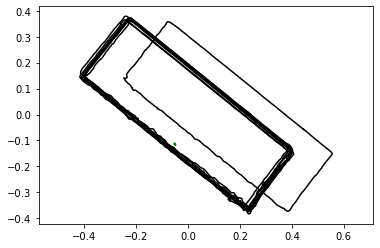

In [44]:
nb.nSobs[0].showIntersections()

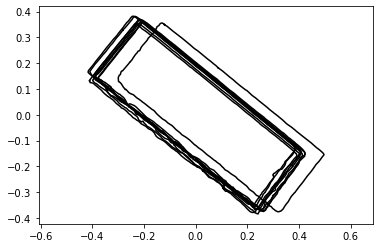

In [45]:
nb.nSobs[1].showIntersections()

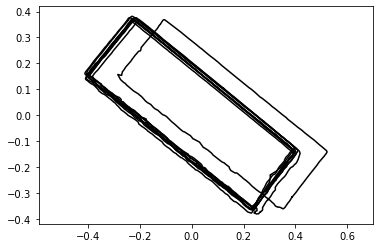

In [46]:
nb.nSobs[2].showIntersections()

In [80]:
sob.SkeletonPoints

[array([0, 0.00913184665597121, 0.00913184665597121], dtype=object),
 array([0.999999999999996, 0.0378895986896018, 0.0378895986896018],
       dtype=object),
 array([2.00000000000001, 0.0684595771579099, 0.0684595771579099],
       dtype=object),
 array([3.00000000000001, 0.100777972510536, 0.100777972510536],
       dtype=object),
 array([4.00000000000001, 0.134780975197123, 0.134780975197123],
       dtype=object),
 array([5.00000000000002, 0.170404775667312, 0.170404775667312],
       dtype=object),
 array([6.00000000000003, 0.207585564370745, 0.207585564370745],
       dtype=object),
 array([7.00000000000002, 0.246259531757062, 0.246259531757062],
       dtype=object),
 array([8.00000000000004, 0.286362868275906, 0.286362868275906],
       dtype=object),
 array([9.00000000000004, 0.327831764376919, 0.327831764376919],
       dtype=object),
 array([10.0000000000001, 0.370602410509742, 0.370602410509742],
       dtype=object),
 array([11.0000000000001, 0.414610997124017, 0.414610997